# Getting Started

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

## Solving ODEs

ODEs can be solved by `neurodiffeq.ode.solve`. 

Just for the sake of notation in the following examples, here we see differentiation as an operation, then an ODE can be rewritten as 

$$F(x, t) = 0.$$

### ODE Example 1: Exponential Decay

Start by solving 

$$\frac{dx}{dt} = -x.$$ 

for $x(t)$ with $x(0) = 1.0$. The analytical solution is 

$$
x = e^{-t}.
$$

For `neurodiffeq.ode.solve` to solve this ODE, the following parameters needs to be specified:

* `ode`: a function representing the ODE to be solved. It should be a function that maps $(x, t)$ to $F(x, t)$. Here we are solving $$F(x, t)=\dfrac{dx}{dt} + x=0,$$ then `ode` should be `lambda x, t: diff(x, t) - x`. `diff(x, t)` is the first order derivative of x with respect to t.

* `condition`: a `neurodiffeq.ode.Condition` instance representing the initial condition / boundary condition of the ODE. Here we use `IVP(t_0=0.0, x_0=1.0)` to ensure $x(0) = 1.0$.

* `t_min` and `t_max`: the domain of $t$ to solve the ODE on.

In [2]:
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition

In [3]:
exponential = lambda x, t: diff(x, t) + x # specify the ODE
init_val_ex = IVP(t_0=0.0, x_0=1.0)       # specify the initial conditon

# solve the ODE
solution_ex, loss_ex = solve(
    ode=exponential, condition=init_val_ex, t_min=0.0, t_max=2.0
)

`solve` returns a tuple, where the first entry is the solution as a function and the second entry is the loss history. The solution is a function that maps $t$ to $x$. It accepts `numpy.array` as input as well. The default return type of the solution is `torch.tensor`. If we wanted to return `numpy.array`, we can specify `as_type='np'`. the loss history is a dictionary, where the 'train_loss' entry is the training loss and the 'valid_loss' entry is the validation loss. Here we compare the ANN-based solution with the analytical solution:

<IPython.core.display.Javascript object>


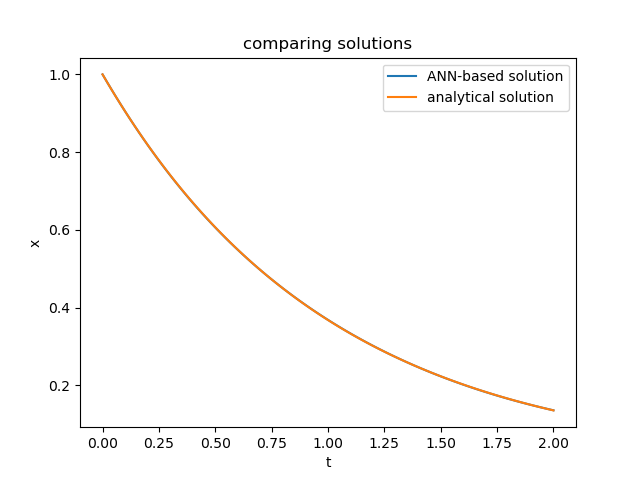

In [4]:
ts = np.linspace(0, 2.0, 100)
x_net = solution_ex(ts, as_type='np')
x_ana = np.exp(-ts)

plt.figure()
plt.plot(ts, x_net, label='ANN-based solution')
plt.plot(ts, x_ana, label='analytical solution')
plt.ylabel('x')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


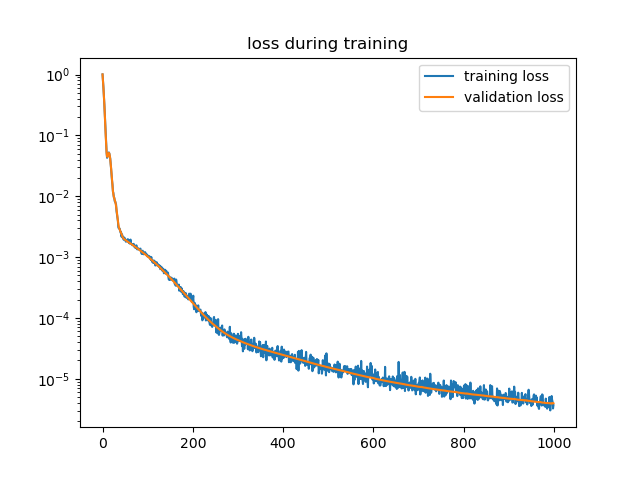

In [5]:
plt.figure()
plt.plot(loss_ex['train_loss'], label='training loss')
plt.plot(loss_ex['valid_loss'], label='validation loss')
plt.yscale('log')
plt.title('loss during training')
plt.legend()
plt.show()

We may want to see the check the solution and the loss function during solving the problem (training the network). To do this, we need to pass a `neurodiffeq.ode.Monitor` object to `solve`. A `Monitor` has the following parameters:

* `t_min` and `t_max`: the region of $t$ we want to monitor
* `check_every`: the frequency of visualization. If `check_every=100`, then the monitor will visualize the solution every 100 epochs.

`%matplotlib notebook` should be executed to allow `Monitor` to work. Here we solve the above ODE again.

In [6]:
from neurodiffeq.ode import Monitor

<IPython.core.display.Javascript object>


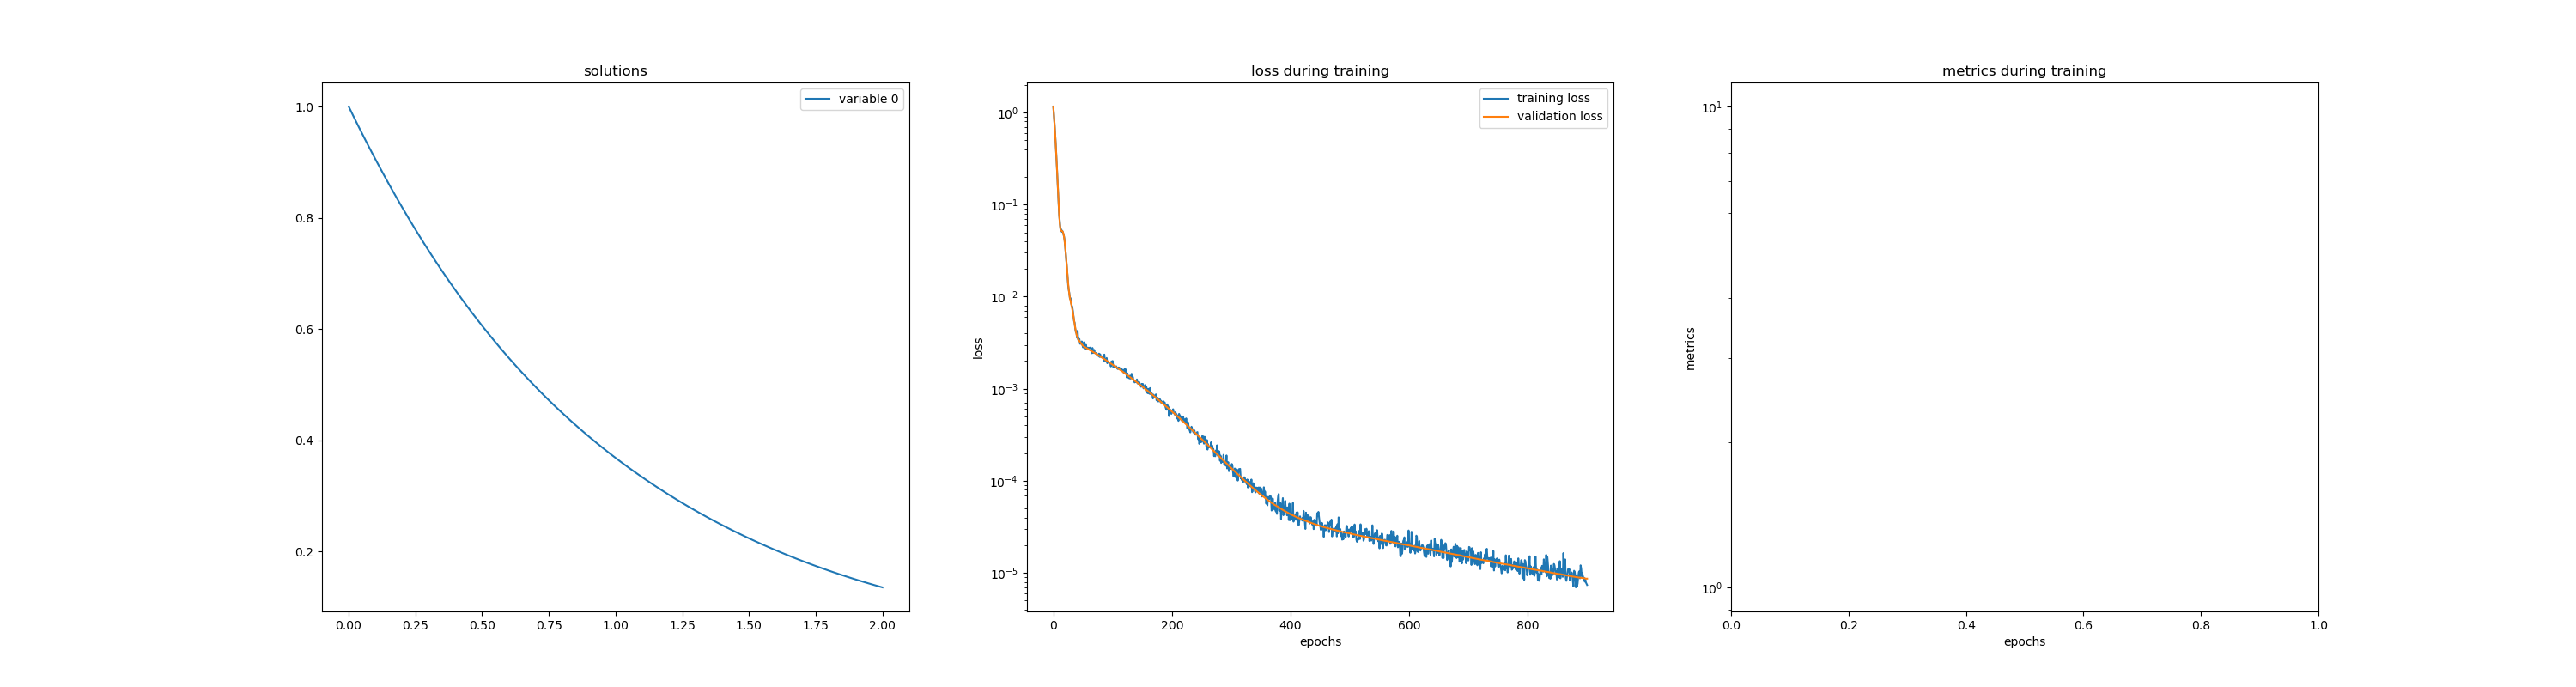

In [7]:
%matplotlib notebook
solution_ex, _ = solve(
    ode=exponential, condition=init_val_ex, t_min=0.0, t_max=2.0, 
    monitor=Monitor(t_min=0.0, t_max=2.0, check_every=100)
)

### ODE Example 2: Harmonic Oscilator

Here we solve a damped harmonic oscillator: 

$$
F(x, t) = \frac{d^2x}{dt^2} + x = 0
$$

for

$$
x(0) = 0.0, \frac{dx}{dt}|_{t=0} = 1.0
$$

The analytical solution is 

$$x = \sin(t)$$

We can include higher order derivatives in our ODE with the `order` keyword of `diff`, which is defaulted to 1.

Initial condition on $\dfrac{dx}{dt}$ can be specified with the `x_0_prime` keyword of `IVP`. 

Here we will use another keyword for `solve`:

* `max_epochs`: the number of epochs to run

<IPython.core.display.Javascript object>


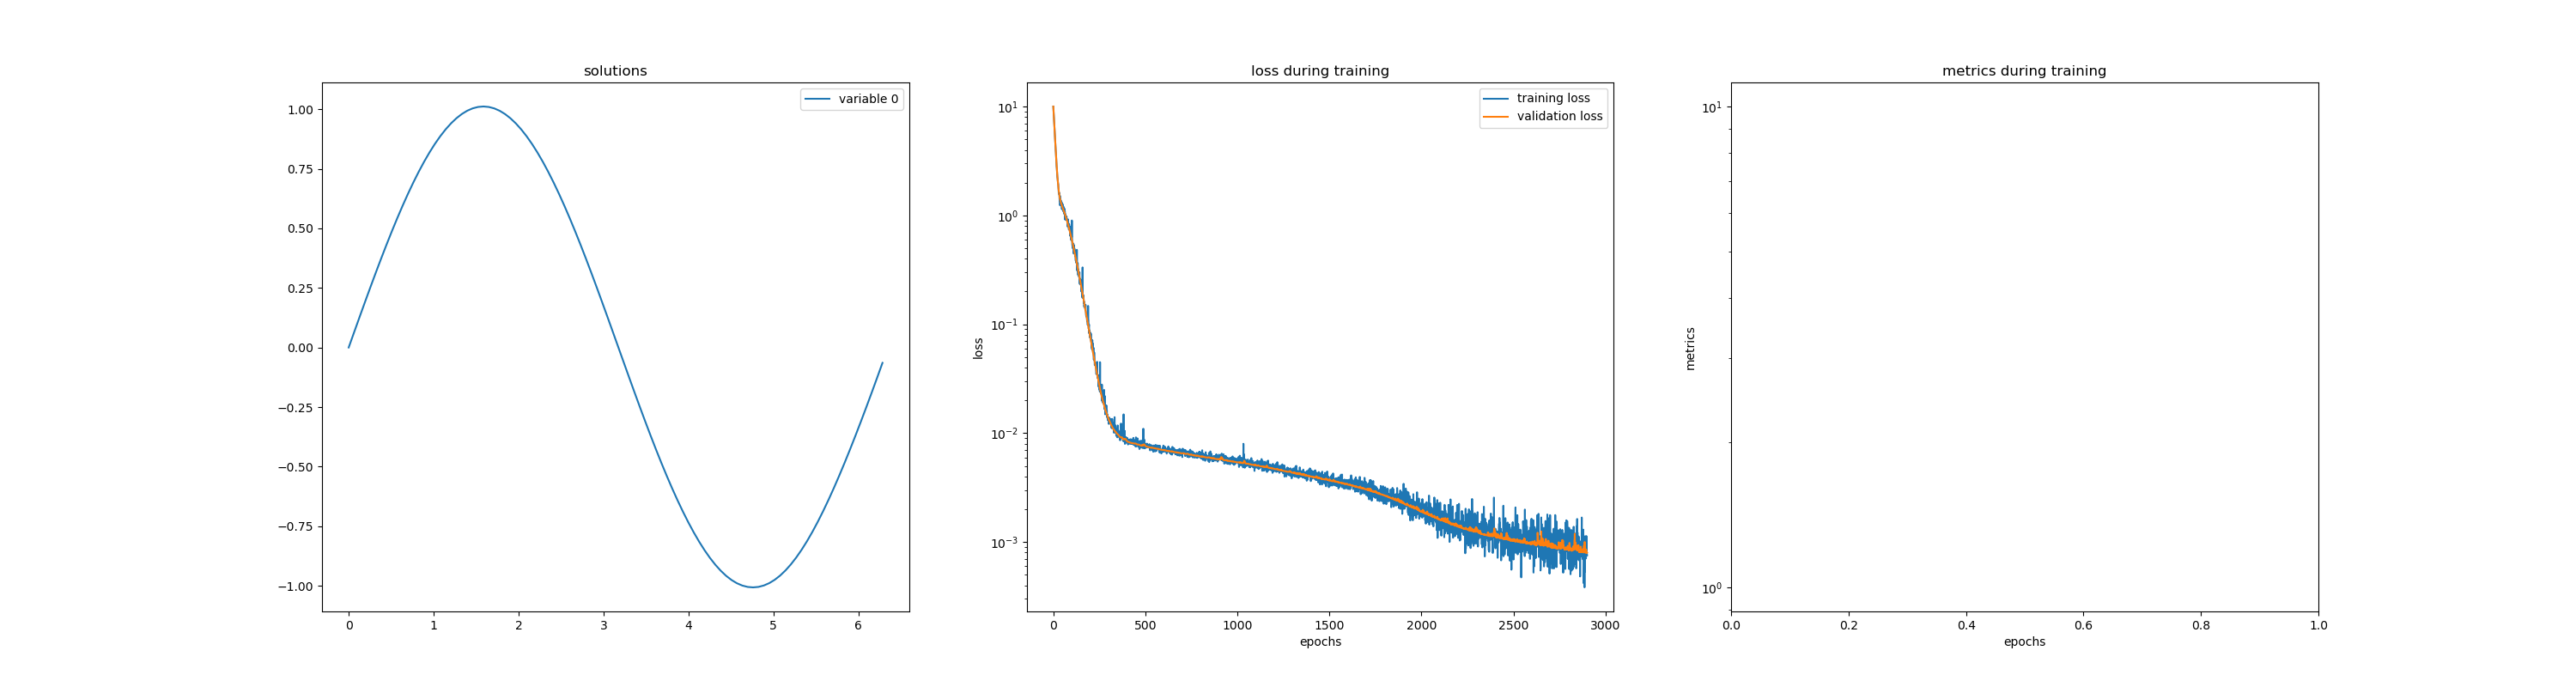

In [8]:
harmonic_oscillator = lambda x, t: diff(x, t, order=2) + x
init_val_ho = IVP(t_0=0.0, x_0=0.0, x_0_prime=1.0)

solution_ho, _ = solve(
    ode=harmonic_oscillator, condition=init_val_ho, t_min=0.0, t_max=2*np.pi, 
    max_epochs=3000,
    monitor=Monitor(t_min=0.0, t_max=2*np.pi, check_every=100)
)

In [9]:
ts = np.linspace(0, 2*np.pi, 100)
x_net = solution_ho(ts, as_type='np')
x_ana = np.sin(ts)

plt.figure()
plt.plot(ts, x_net, label='ANN-based solution')
plt.plot(ts, x_ana, label='analytical solution')
plt.ylabel('x')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

## Solving Systems of ODEs

Systems of ODEs can be solved by `neurodiffeq.ode.solve_system`. 

Again, just for the sake of notation in the following examples, here we see differentiation as an operation, and see each element $x_i$of $\vec{x}$ as different dependent vairables, then a ODE system above can be rewritten as

$$
\begin{pmatrix} 
F_0(x_0, x_1, \ldots, x_{m-1}, t) \\
F_1(x_0, x_1, \ldots, x_{m-1}, t) \\
\vdots \\
F_{m-1}(x_0, x_1, \ldots, x_{m-1}, t)
\end{pmatrix}
= 
\begin{pmatrix} 
0 \\
0 \\
\vdots \\
0
\end{pmatrix}
$$

### Systems of ODE Example 1: Harmonic Oscilator

For the harmonic oscillator example above, if we let $x_1 = x$ and $x_2 = \dfrac{dx}{dt}$. We can rewrite this ODE into a system of ODE:

$$\begin{align}
x_1^{'} - x_2 &= 0, \\
x_2^{'} + x_1 &= 0, \\
x_1(0) &= 0, \\
x_2(0) &= 1.
\end{align}$$

Here the analytical solution is 
$$\begin{align}
x_1 &= \sin(t), \\
x_2 &= \cos(t).
\end{align}$$

The `solve_system` function is for solving ODE systems. The signature is almost the same as `solve` except that we specify an `ode_system` and a set of `conditions`. 

* `ode_system`: a function representing the system of ODEs to be solved. If the our system of ODEs is $f_i(x_0, x_1, ..., x_{m-1}, t) = 0$ for $i = 0, 1, ..., n-1$ where $x_0, x_1, ..., x_{m-1}$ are dependent variables and $t$ is the independent variable, then `ode_system` should map $(x_0, x_1, ..., x_{m-1}, t)$ to a $n$-element list where the $i^{th}$ element is the value of $f_i(x_0, x_1, ..., x_{m-1}, t)$.

* `conditions`: the initial value/boundary conditions as a list of Condition instance. They should be in an order such that the first condition constraints the first variable in $f_i$'s (see above) signature ($x_0$). The second condition constraints the second ($x_1$), and so on.

In [10]:
from neurodiffeq.ode import solve_system

<IPython.core.display.Javascript object>


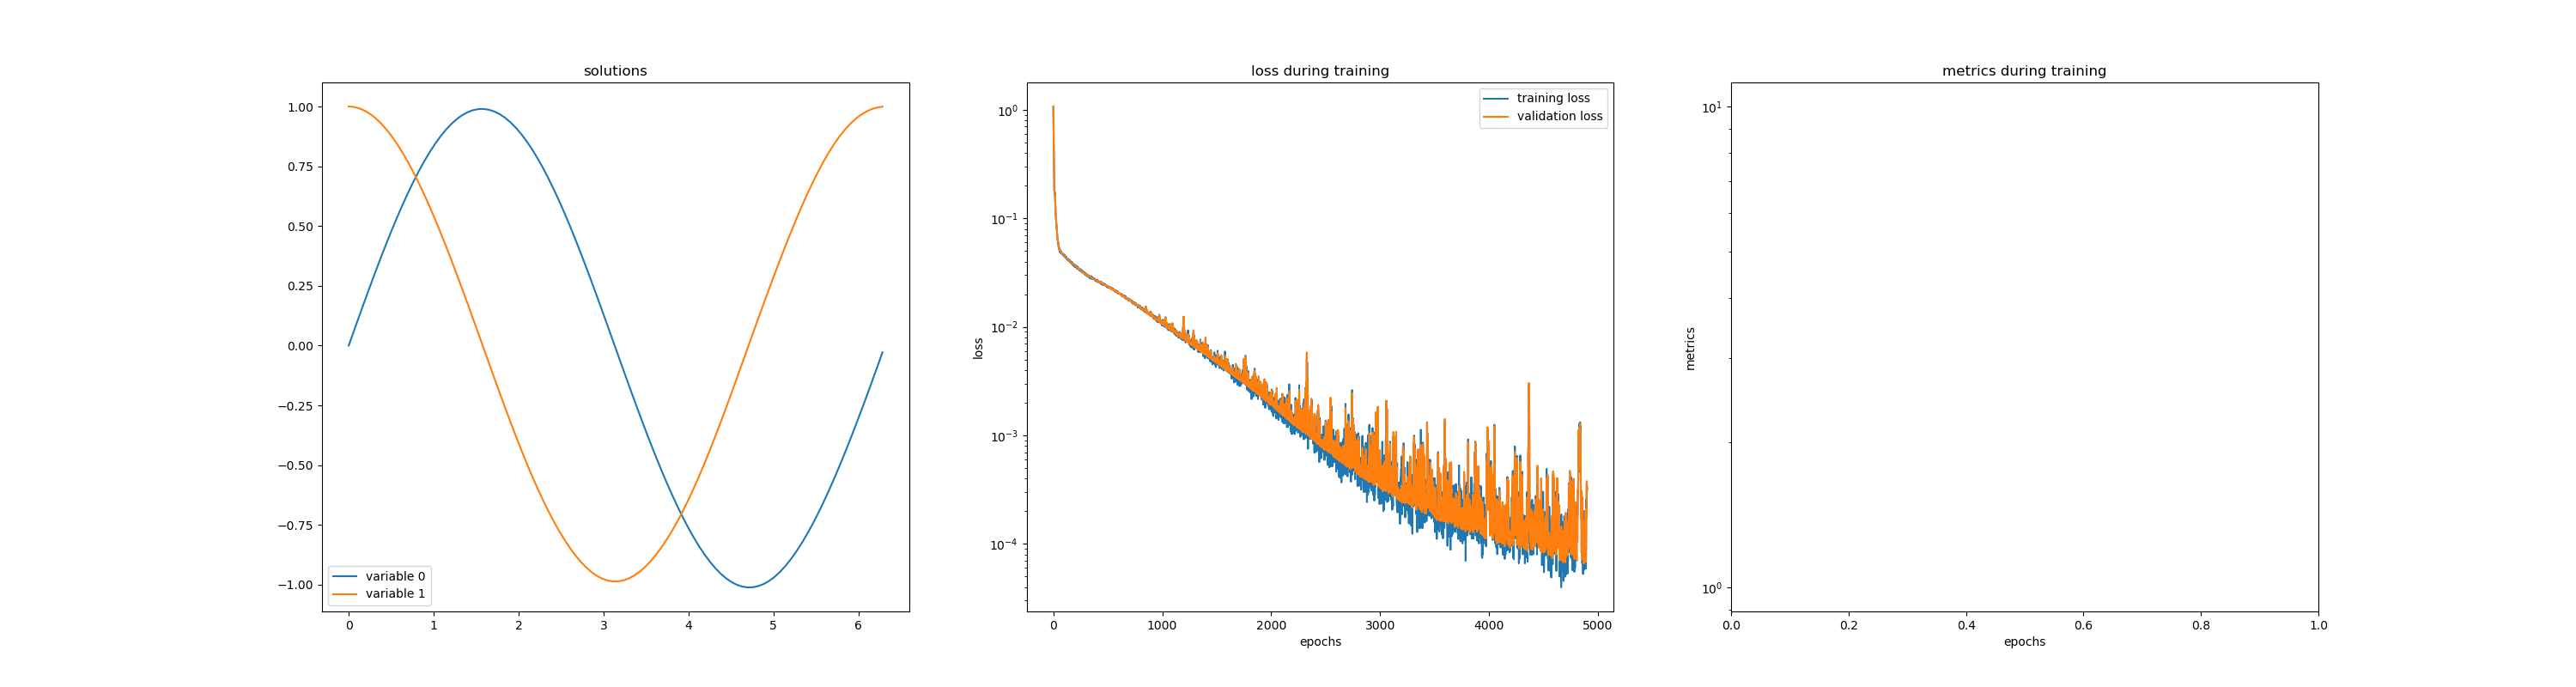

In [11]:
# specify the ODE system
parametric_circle = lambda x1, x2, t : [diff(x1, t) - x2, 
                                        diff(x2, t) + x1]
# specify the initial conditions
init_vals_pc = [
    IVP(t_0=0.0, x_0=0.0),
    IVP(t_0=0.0, x_0=1.0)
]

# solve the ODE system
solution_pc, _ = solve_system(
    ode_system=parametric_circle, conditions=init_vals_pc, t_min=0.0, t_max=2*np.pi, 
    max_epochs=5000,
    monitor=Monitor(t_min=0.0, t_max=2*np.pi, check_every=100)
)

`solve_system` returns a tuple, where the first entry is the solution as a function and the second entry is the loss history as a list. The solution is a function that maps $t$ to $[x_0, x_1, ..., x_{m-1}]$. It accepts `numpy.array` as input as well. Here we compare the ANN-based solution with the analytical solution:

In [12]:
ts = np.linspace(0, 2*np.pi, 100)
x1_net, x2_net = solution_pc(ts, as_type='np')
x1_ana, x2_ana = np.sin(ts), np.cos(ts)

plt.figure()
plt.plot(ts, x1_net, label='ANN-based solution of x1')
plt.plot(ts, x1_ana, label='analytical solution of x1')
plt.plot(ts, x2_net, label='ANN-based solution of x2')
plt.plot(ts, x2_ana, label='analytical solution of x2')
plt.ylabel('x')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

### Systems of ODE Example 2: Lotka–Volterra equations

Lotka–Volterra equations are a pair of nonlinear ODE frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey:

$$\begin{align}
\frac{dx}{dt} = \alpha x - \beta xy \\
\frac{dy}{dt} = \delta xy - \gamma y
\end{align}$$

Let $\alpha = \beta = \delta = \gamma = 1$. Here we solve this pair of ODE when $x(0) = 1.5$ and $y(0) = 1.0$.

If not specified otherwise, `solve` and `solve_system` will use a fully-connected network with 1 hidden layer with 32 hidden units (tanh activation) to approximate each dependent variables. In some situations, we may want to use our own neural network. For example, the default neural net is not good at solving a problem where the solution oscillates. However, if we know in advance that the solution oscillates, we can use sin as activation function, which resulted in much faster convergence.

`neurodiffeq.FCNN` is a fully connected neural network. It is initiated by the following parameters:

* `hidden_units`: number of units in each hidden layer. If you have 3 hidden layers with 32, 64, and 16 neurons respectively, `hidden_units` should be a tuple `(32, 64, 16)`.

* `actv`: a `torch.nn.Module` *class*. e.g. `nn.Tanh`, `nn.Sigmoid`.

Here we will use another keyword for `solve_system`:

* `nets`: a list of networks to be used to approximate each dependent variable

In [13]:
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation

<IPython.core.display.Javascript object>


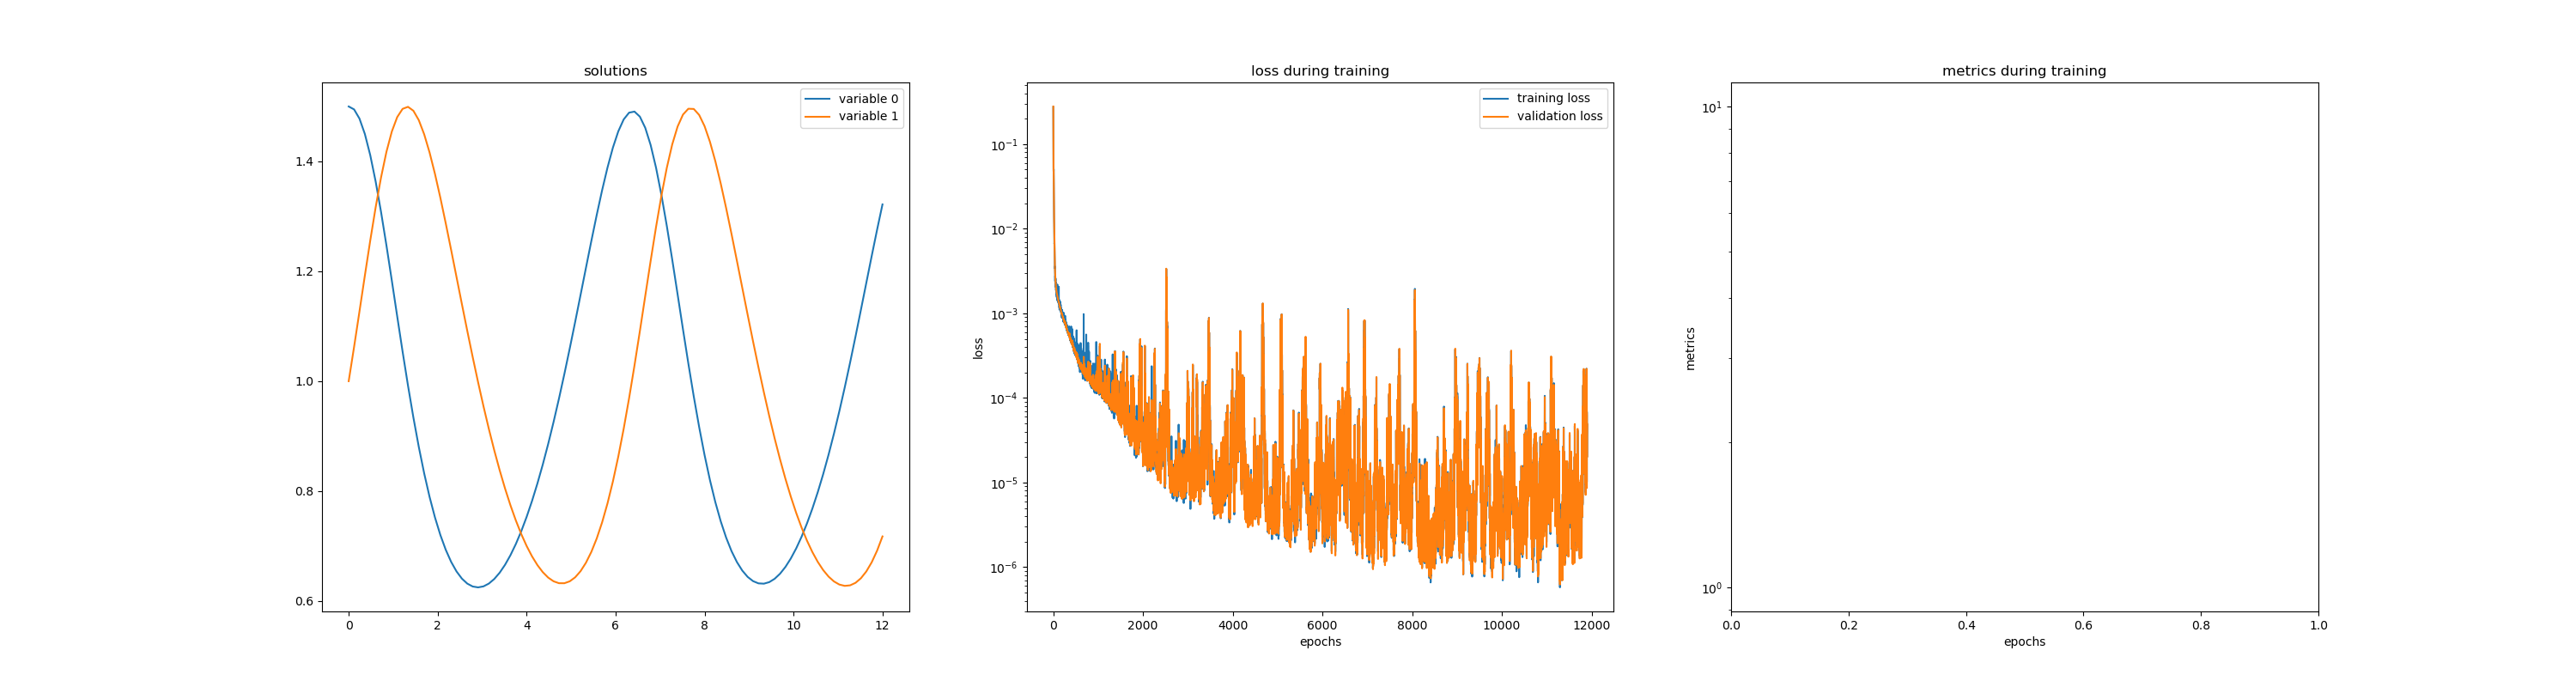

In [14]:
# specify the ODE system and its parameters
alpha, beta, delta, gamma = 1, 1, 1, 1
lotka_volterra = lambda x, y, t : [diff(x, t) - (alpha*x  - beta*x*y), 
                                   diff(y, t) - (delta*x*y - gamma*y)]
# specify the initial conditions
init_vals_lv = [
    IVP(t_0=0.0, x_0=1.5),
    IVP(t_0=0.0, x_0=1.0)
]

# specify the network to be used to approximate each dependent variable
nets_lv = [
    FCNN(hidden_units=(32, 32), actv=SinActv),
    FCNN(hidden_units=(32, 32), actv=SinActv)
]

# solve the ODE system
solution_lv, _ = solve_system(
    ode_system=lotka_volterra, conditions=init_vals_lv, t_min=0.0, t_max=12, 
    nets=nets_lv, max_epochs=12000,
    monitor=Monitor(t_min=0.0, t_max=12, check_every=100)
)

In [15]:
ts = np.linspace(0, 12, 100)

# ANN-based solution
prey_net, pred_net = solution_lv(ts, as_type='np')

# numerical solution
from scipy.integrate import odeint
def dPdt(P, t):
    return [P[0]*alpha - beta*P[0]*P[1], delta*P[0]*P[1] - gamma*P[1]]
P0 = [1.5, 1.0]
Ps = odeint(dPdt, P0, ts)
prey_num = Ps[:,0]
pred_num = Ps[:,1]

plt.figure()
plt.plot(ts, prey_net, label='ANN-based solution of prey')
plt.plot(ts, prey_num, label='numerical solution of prey')
plt.plot(ts, pred_net, label='ANN-based solution of predator')
plt.plot(ts, pred_num, label='numerical solution of predator')
plt.ylabel('population')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

## Solving PDEs

PDEs can be solved by `neurodiffeq.pde.solve2D`. Currently `neurodiffeq` only support solving PDEs with 2 independent variables.

Aain, just for the sake of notation in the following examples, here we see differentiation as an operation, then an PDE of $u(x, y)$ can be rewritten as: 

$$F(u, x, y) = 0.$$

### PDE Example 1: Laplace's Equation

Here we solve 2-D Laplace equation on a Cartesian boundary with Dirichlet boundary condition:

$$
F(u, x, y) = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0
$$

for $(x, y) \in [0, 1] \times [0, 1]$

s.t.

$$
u(x, y)\bigg|_{x=0} = \sin(\pi y) \\
u(x, y)\bigg|_{x=1} = 0 \\
u(x, y)\bigg|_{y=0} = 0 \\
u(x, y)\bigg|_{y=1} = 0
$$

The analytical solution is

$$
u(x, y) = \frac{\sin(\pi y) \sinh(\pi(1-x))}{\sinh(\pi)}
$$

Here we have a Dirichlet boundary condition on both 4 edges of the orthogonal box. We will be using `DirichletBVP2D` for this boundary condition. The arguments `x_min_val`, `x_max_val`, `y_min_val` and `y_max_val` correspond to $u(x, y)\bigg|_{x=0}$, $u(x, y)\bigg|_{x=1}$, $u(x, y)\bigg|_{y=0}$ and $u(x, y)\bigg|_{y=1}$. Note that they should all be functions of $x$ or $y$. These functions are expected to take in a `torch.tensor` and return a `torch.tensor`, so if the function involves some elementary functions like $\sin$, we should use `torch.sin` instead of `numpy.sin`.

The `solve2D` function is almost the same as `solve` and `solve_system` in the `ode` module. The difference is that we indicate the domain of our problem with `xy_min` and `xy_max`, they are tuples representing the 'lower left' point and 'upper right' point of our domain. Also, we need to use `ExampleGenerator2D` and `Monitor2D` from the `pde` module.

In [16]:
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.pde import solve2D, Monitor2D
from neurodiffeq.generators import Generator2D
import torch

<IPython.core.display.Javascript object>


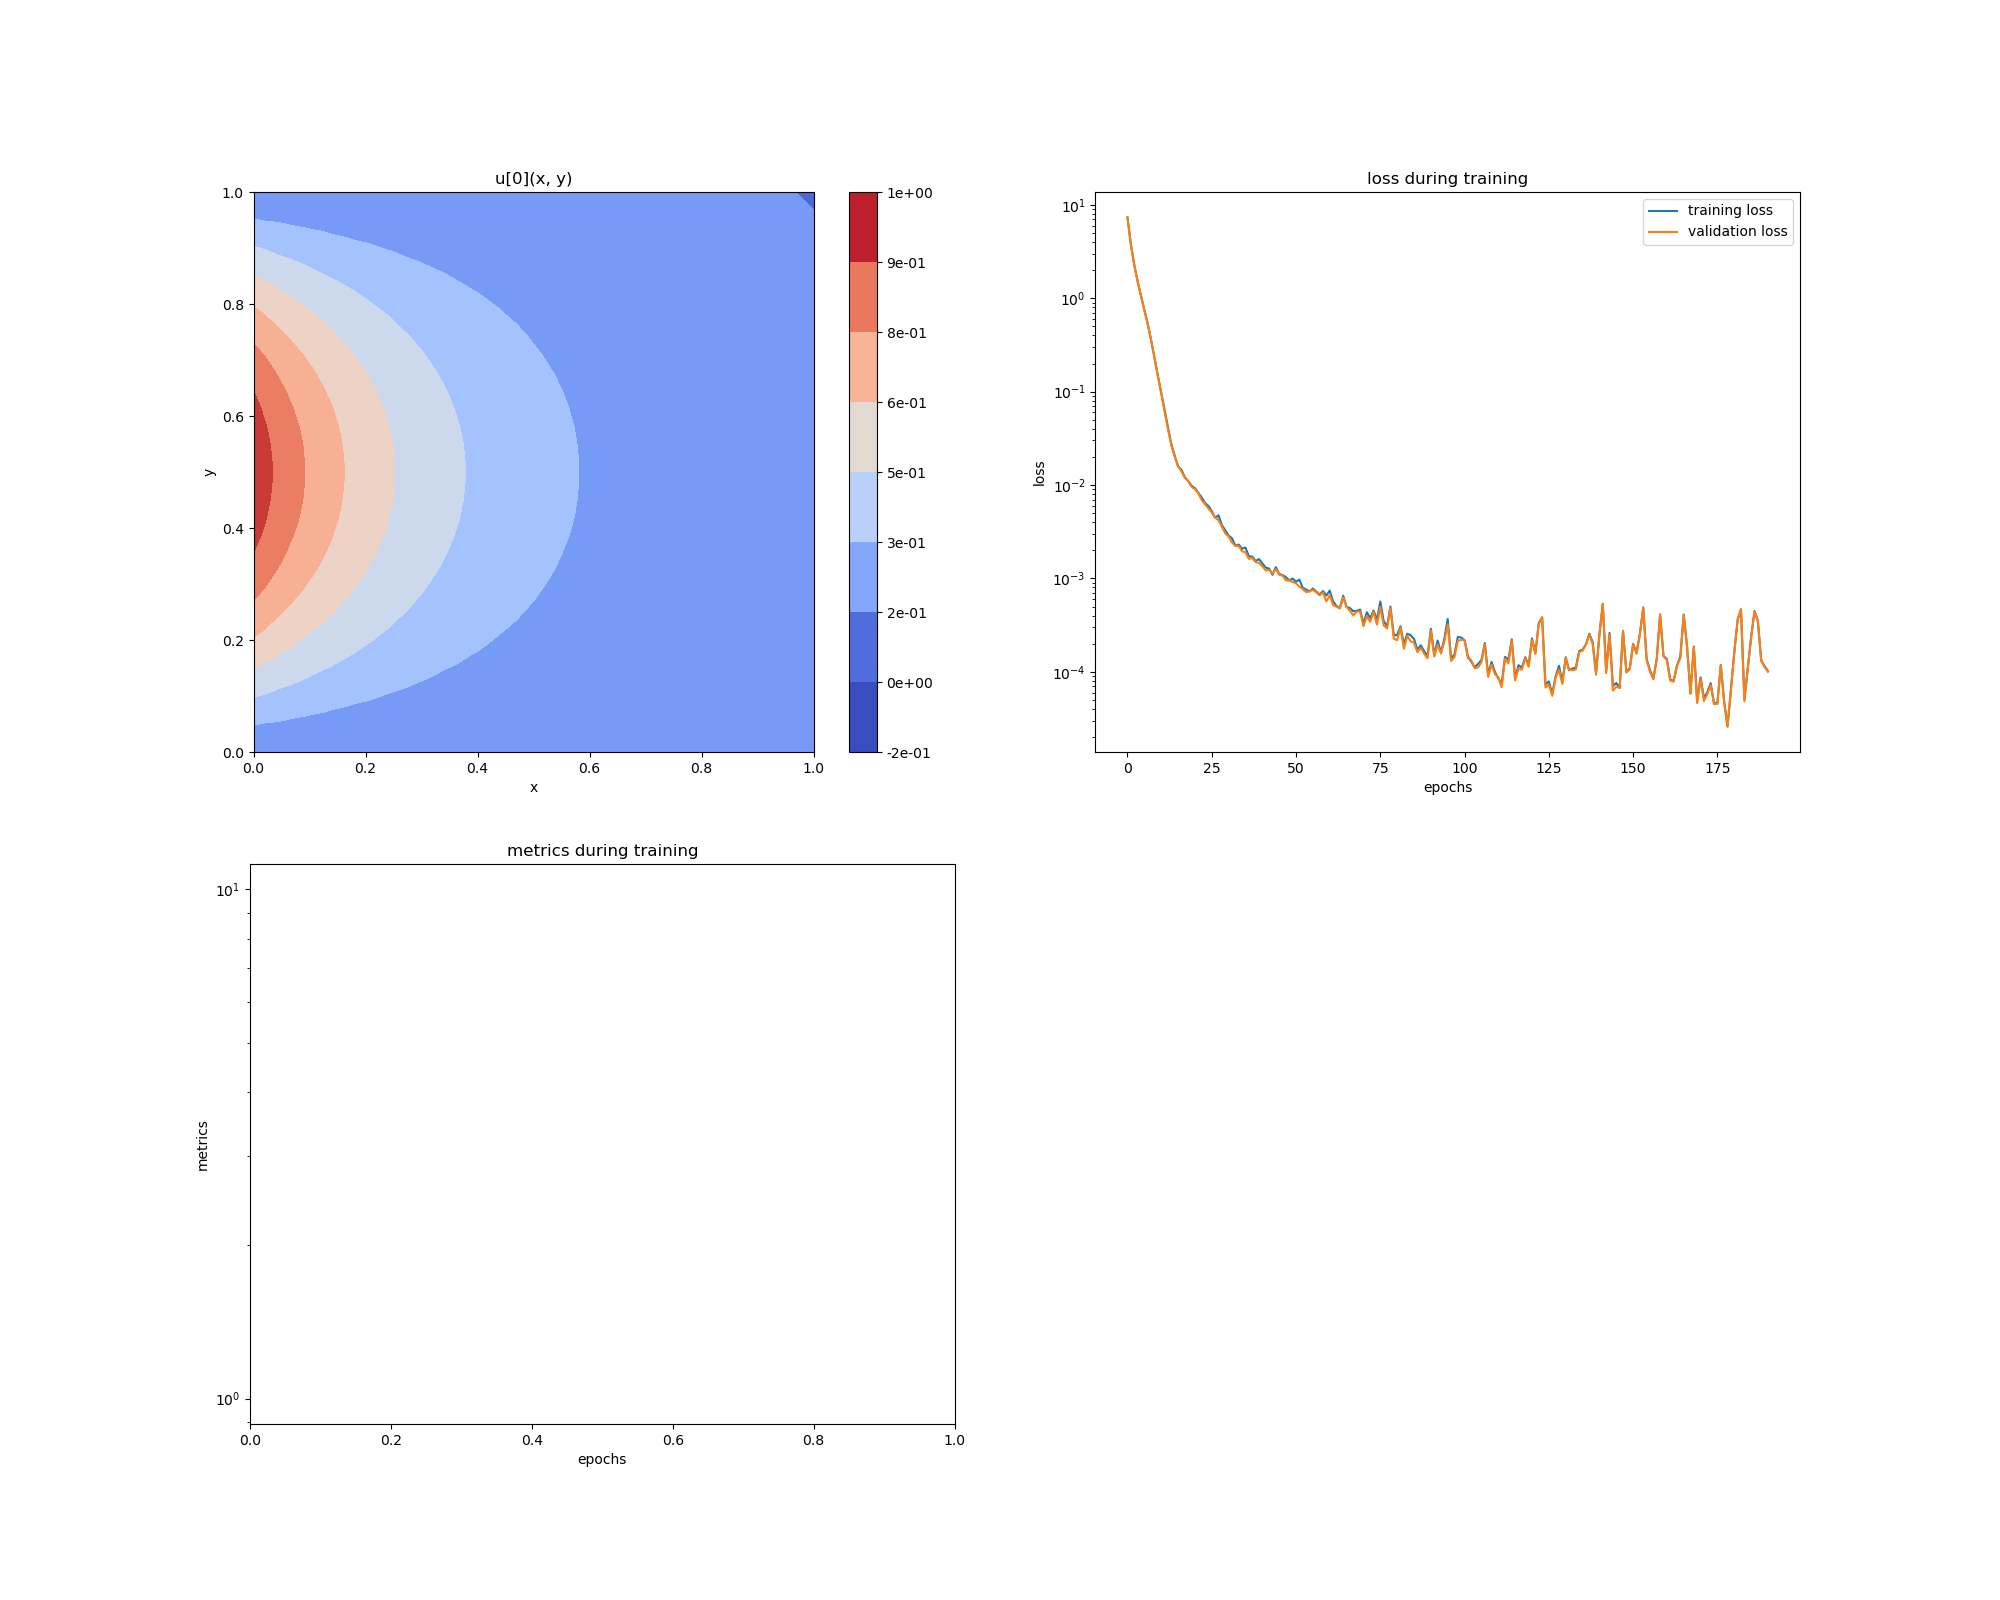

In [17]:
laplace = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2)
bc = DirichletBVP2D(
    x_min=0, x_min_val=lambda y: torch.sin(np.pi*y), 
    x_max=1, x_max_val=lambda y: 0, 
    y_min=0, y_min_val=lambda x: 0, 
    y_max=1, y_max_val=lambda x: 0
)
net = FCNN(n_input_units=2, hidden_units=(32, 32))

solution_neural_net_laplace, _ = solve2D(
    pde=laplace, condition=bc, xy_min=(0, 0), xy_max=(1, 1),
    net=net, max_epochs=200, train_generator=Generator2D(
        (32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'
    ),
    monitor=Monitor2D(check_every=10, xy_min=(0, 0), xy_max=(1, 1))
)

Here we create a function to help us visualize the shape of the solution and the residual.

In [18]:
from mpl_toolkits.mplot3d  import Axes3D
def plt_surf(xx, yy, zz, z_label='u', x_label='x', y_label='y', title=''):
    fig  = plt.figure(figsize=(16, 8))
    ax   = Axes3D(fig)
    surf = ax.plot_surface(xx, yy, zz, rstride=2, cstride=1, alpha=0.8, cmap='hot')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)
    ax.set_proj_type('ortho')
    plt.show()

In [19]:
xs, ys = np.linspace(0, 1, 101), np.linspace(0, 1, 101)
xx, yy = np.meshgrid(xs, ys)
sol_net = solution_neural_net_laplace(xx, yy, as_type='np')
plt_surf(xx, yy, sol_net, title='u(x, y) as solved by neural network')

<IPython.core.display.Javascript object>

In [20]:
solution_analytical_laplace = lambda x, y: np.sin(np.pi*y) * np.sinh(np.pi*(1-x))/np.sinh(np.pi)
sol_ana = solution_analytical_laplace(xx, yy)
plt_surf(xx, yy, sol_net-sol_ana, z_label='residual', title='residual of the neural network solution')

<IPython.core.display.Javascript object>

### PDE Example 2: 1-D Heat Equation

Here we solve 1-D heat equation:

$$
\frac{\partial u}{\partial t} - k \frac{\partial^2 u}{\partial x^2} = 0
$$

with an initial condition and 2 Neumann boundary on each end:

$$
u(x, t)\bigg|_{t=0} = \sin(\pi x) \\
\frac{\partial u(x, t)}{\partial x}\bigg|_{x=0} = \pi\exp(-k\pi^2 t) \\
\frac{\partial u(x, t)}{\partial x}\bigg|_{x=1} = -\pi\exp(-k\pi^2 t)
$$

The analytical solution is:

$$
u(x, t) = \sin(\pi \frac{x}{L}) \exp(\frac{-k \pi^2 t}{L^2})
$$

Since we are still solving in a 2-D space ($x$ and $t$), we will still be using `solve2D`. We use a `IBVP1D` condition to enforce our initial and boundary condition. The arguments `t_min_val`, `x_min_prime`, and `x_max_prime` correspond to $u(x, t)\bigg|_{t=0}$, $\displaystyle\frac{\partial u(x, t)}{\partial x}\bigg|_{x=0}$ and $\displaystyle\frac{\partial u(x, t)}{\partial x}\bigg|_{x=1}$.

In [21]:
from neurodiffeq.conditions import IBVP1D 
from neurodiffeq.pde import make_animation

<IPython.core.display.Javascript object>


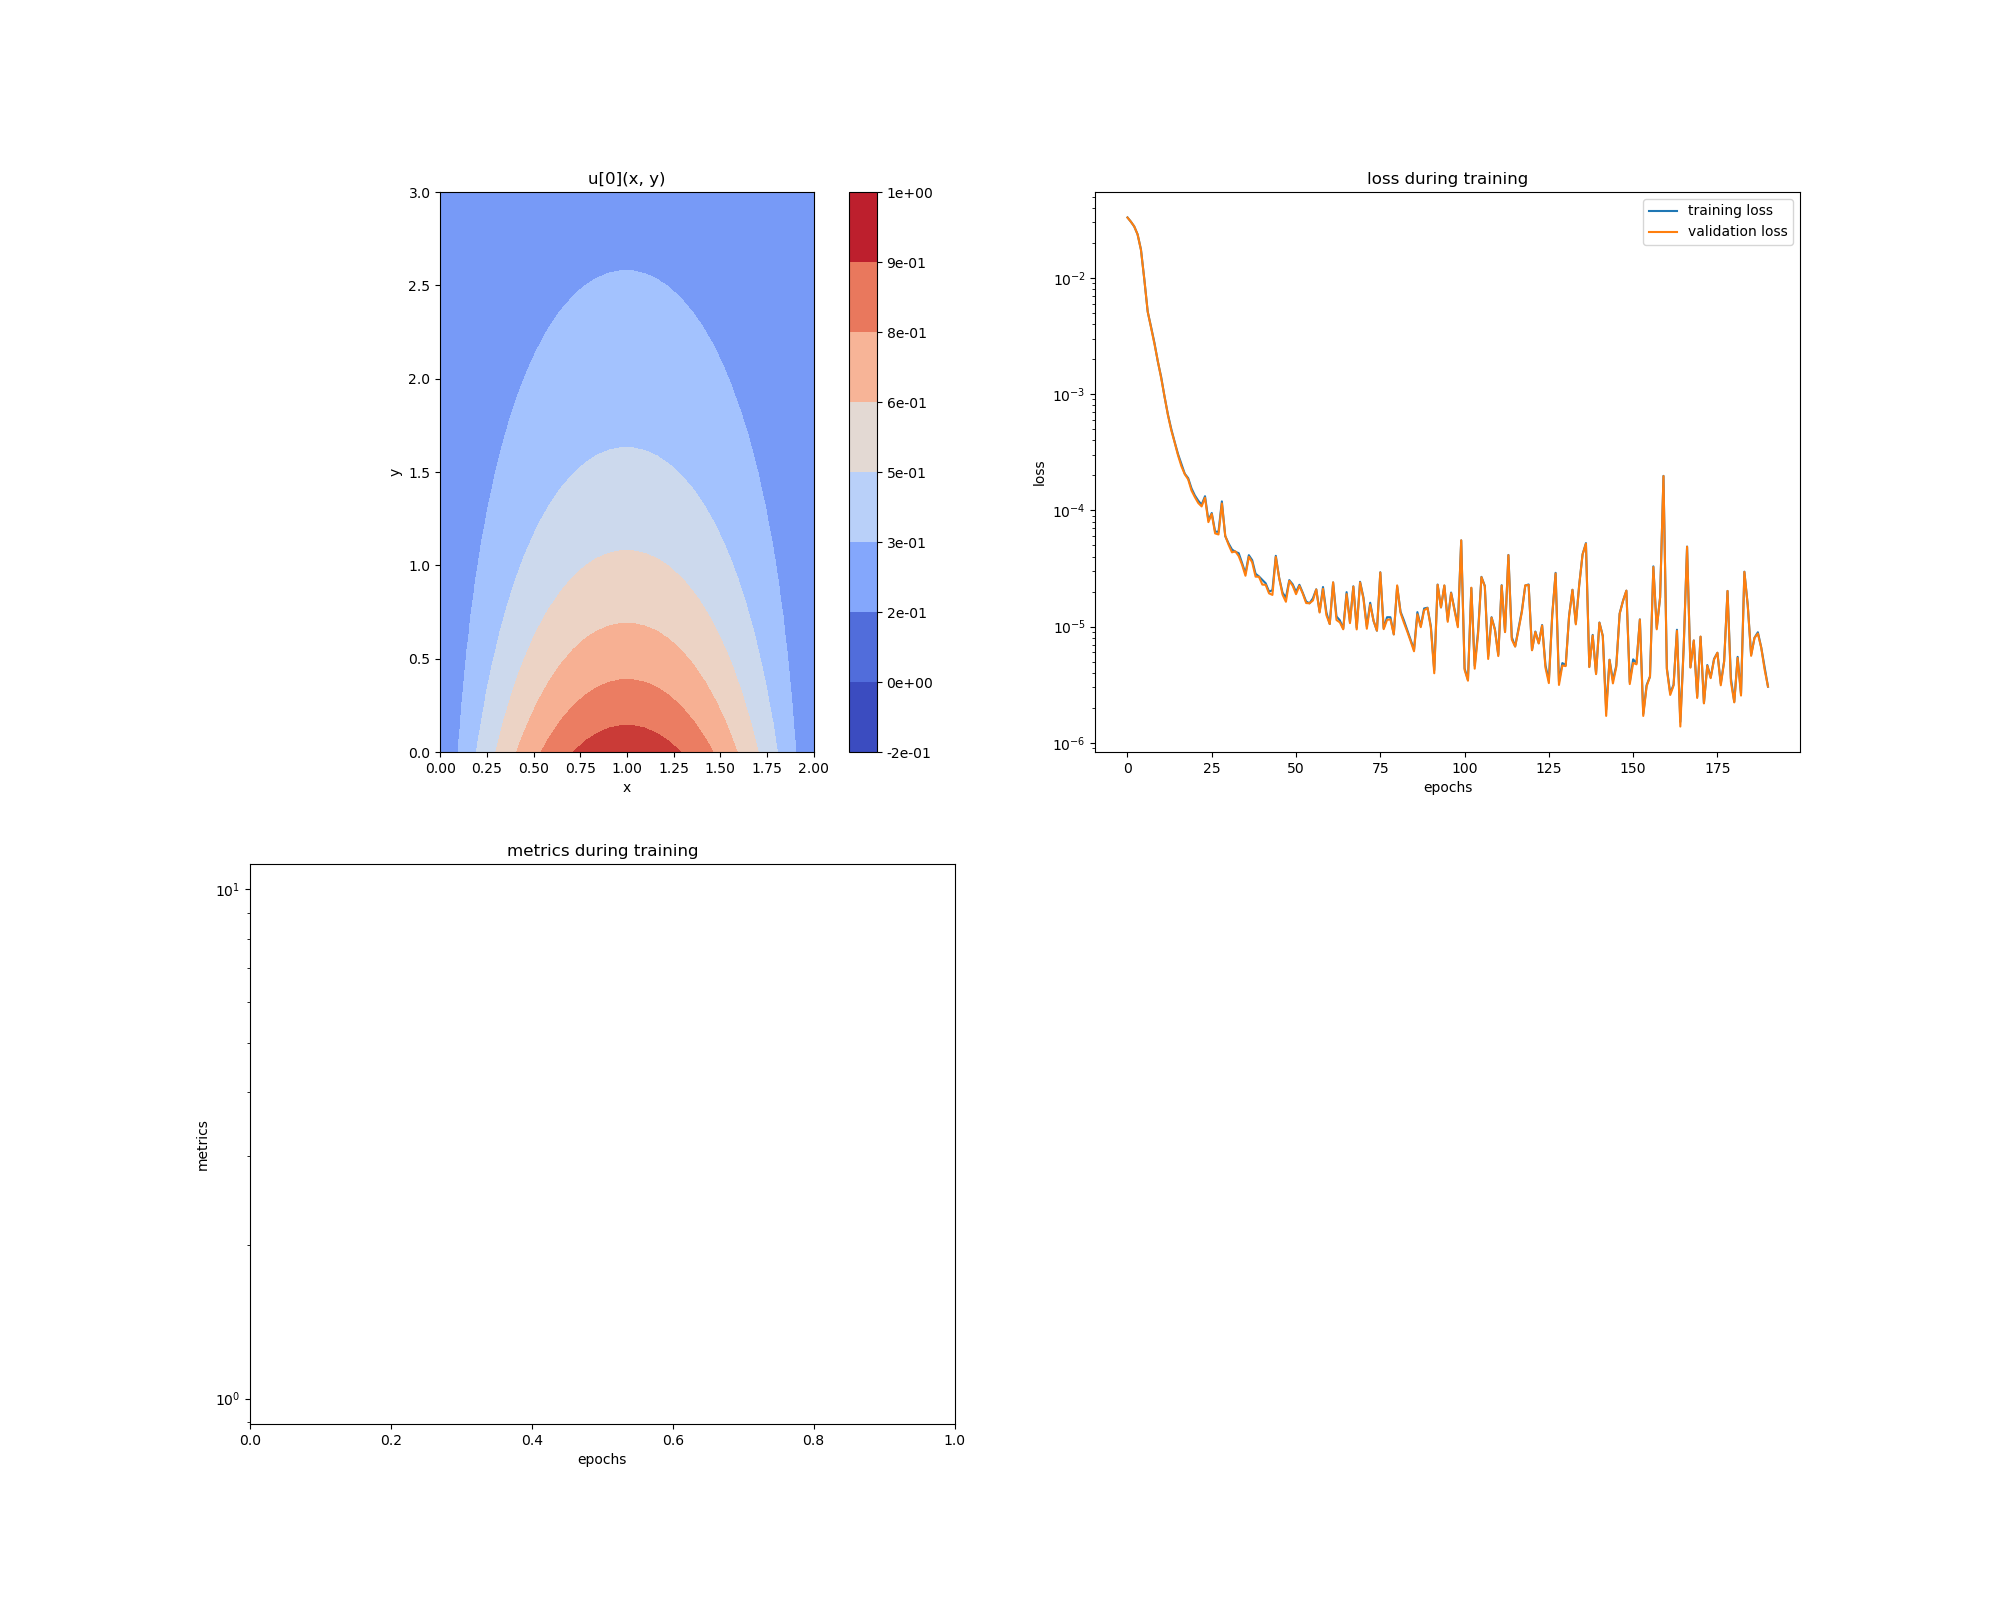

In [22]:
k, L, T = 0.3, 2, 3
heat = lambda u, x, t: diff(u, t) - k * diff(u, x, order=2)

ibvp = IBVP1D(
    t_min=0, t_min_val=lambda x: torch.sin(np.pi * x / L),
    x_min=0, x_min_prime=lambda t:  np.pi/L * torch.exp(-k*np.pi**2*t/L**2),
    x_max=L, x_max_prime=lambda t: -np.pi/L * torch.exp(-k*np.pi**2*t/L**2)
)
net = FCNN(n_input_units=2, hidden_units=(32, 32))

solution_neural_net_heat, _ = solve2D(
    pde=heat, condition=ibvp, xy_min=(0, 0), xy_max=(L, T),
    net=net, max_epochs=200, train_generator=Generator2D(
        (32, 32), (0, 0), (L, T), method='equally-spaced-noisy'
    ),
    monitor=Monitor2D(check_every=10, xy_min=(0, 0), xy_max=(L, T))
)

We can use `make_animation` to animate the solution. Here we also check the residual of our solution.

In [23]:
xs = np.linspace(0, L, 101)
ts = np.linspace(0, T, 101) 
xx, tt = np.meshgrid(xs, ts)
make_animation(solution_neural_net_heat, xs, ts)

<IPython.core.display.Javascript object>

In [24]:
solution_analytical_heat = lambda x, t: np.sin(np.pi*x/L) * np.exp(-k * np.pi**2 * t / L**2)
sol_ana = solution_analytical_heat(xx, tt)
sol_net = solution_neural_net_heat(xx, tt, as_type='np')
plt_surf(xx, tt, sol_net-sol_ana, y_label='t', z_label='residual of the neural network solution')

<IPython.core.display.Javascript object>

## Irregular Domain

In [25]:
import numpy as np
import torch
from torch import nn
from torch import optim
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.pde import solve2D, Monitor2D
from neurodiffeq.generators import Generator2D, PredefinedGenerator
from neurodiffeq.pde import CustomBoundaryCondition, Point, DirichletControlPoint
import matplotlib.pyplot as plt
import matplotlib.tri as tri

`neurodiffeq` also implemented a method (https://ieeexplore.ieee.org/document/5061501) to impose Dirichlet boundary condition on an irregular domain. Here we show a problem that is defined on a star shaped domain. The following cell are some helper functions we will use later.

In [26]:
def get_grid(x_from_to, y_from_to, x_n_points=100, y_n_points=100, as_tensor=False):
    x_from, x_to = x_from_to
    y_from, y_to = y_from_to
    if as_tensor:
        x = torch.linspace(x_from, x_to, x_n_points)
        y = torch.linspace(y_from, y_to, y_n_points)
        return torch.meshgrid(x, y)
    else:
        x = np.linspace(x_from, x_to, x_n_points)
        y = np.linspace(y_from, y_to, y_n_points)
        return np.meshgrid(x, y)

def create_contour(ax, xs, ys, zs, cdbc=None):
    triang = tri.Triangulation(xs, ys)
    xs = xs[triang.triangles].mean(axis=1) 
    ys = ys[triang.triangles].mean(axis=1)
    if cdbc:
        xs, ys = torch.tensor(xs), torch.tensor(ys)
        in_domain = cdbc.in_domain(xs, ys).detach().numpy()
        triang.set_mask(~in_domain)
    
    contour = ax.tricontourf(triang, zs, cmap='coolwarm')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', adjustable='box')
    return contour

def compare_contour(sol_net, sol_ana, eval_on_xs, eval_on_ys, cdbc=None):
    eval_on_xs, eval_on_ys = eval_on_xs.flatten(), eval_on_ys.flatten()
    s_net = sol_net(eval_on_xs, eval_on_ys, as_type='np')
    s_ana = sol_ana(eval_on_xs, eval_on_ys)
    
    fig = plt.figure(figsize=(18, 4))
    
    ax1 = fig.add_subplot(131)
    cs1 = create_contour(ax1, eval_on_xs, eval_on_ys, s_net, cdbc)
    ax1.set_title('ANN-based solution')
    cbar1 = fig.colorbar(cs1, format='%.0e', ax=ax1)
    
    ax2 = fig.add_subplot(132)
    cs2 = create_contour(ax2, eval_on_xs, eval_on_ys, s_ana, cdbc)
    ax2.set_title('analytical solution')
    cbar2 = fig.colorbar(cs2, format='%.0e', ax=ax2)
    
    ax3 = fig.add_subplot(133)
    cs3 = create_contour(ax3, eval_on_xs, eval_on_ys, s_net-s_ana, cdbc)
    ax3.set_title('residual of ANN-based solution')
    cbar3 = fig.colorbar(cs3, format='%.0e', ax=ax3)


The problem we want to solve is defined on a hexagram that is centered at the origin. The uppermost vertex of the hexagram locates at $(0, 1)$ and the lowermost vertex locates at $(0, -1)$. The differential equation is:

$$\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2} + e^{u} = 1 + x^2 + y^2 + \dfrac{4}{(1+x^2+y^2)^2}$$

We have a Dirichlet condition along the boundary of the domain:

$$u(x, y) = \ln(1+x^2+y^2)$$

The analytical solution is:

$$u(x, y) = \ln(1+x^2+y^2)$$

In [27]:
def solution_analytical_star(x, y):
    return np.log(1+x**2+y**2)

`neurodiffeq.pde.CustomBoundaryCondition` imposes boundary condition on a irregular domain. To specify this domain, we will pass to `CustomBoundaryCondition` a collection of control points that fall on the boundary. Here on each edge of the hexagram, we create 11 `neurodiffeq.pde.DirichletControlPoint` that impose the value of $u$ at these location. This collection of `DirichletControlPoint` are then passed to `CustomBoundaryCondition` to fit the trial solution.

In [28]:
edge_length = 2.0 / np.sin(np.pi/3) / 4
points_on_each_edge = 11
step_size = edge_length / (points_on_each_edge-1)

direction_theta  =  np.pi*2/3
left_turn_theta  =  np.pi*1/3
right_turn_theta = -np.pi*2/3

control_points_star = []
point_x, point_y = 0.0, -1.0
for i_edge in range(12):
    for i_step in range(points_on_each_edge-1):
        control_points_star.append(
            DirichletControlPoint(
                loc=(point_x, point_y), 
                val=solution_analytical_star(point_x, point_y)
            )
        ) 
        point_x += step_size*np.cos(direction_theta)
        point_y += step_size*np.sin(direction_theta)
    direction_theta += left_turn_theta if (i_edge % 2 == 0) else right_turn_theta

cdbc_star = CustomBoundaryCondition( 
    center_point=Point((0.0, 0.0)),
    dirichlet_control_points=control_points_star
)

Here we use a set of predifined points as our training set. These points are from a $32 \times 32$ grid in $(-1, 1) \times (-1, 1)$. We filter out the points that don't fall in the domain (`CustomBoundaryCondition` has an `in_domain` method that returns a mask of points that are in the domain) and use the rest as the training set. We also specify a validation set that is denser.

In [29]:
%matplotlib notebook
def to_np(tensor):
    return tensor.detach().numpy()

xx_train, yy_train = get_grid(
    x_from_to=(-1, 1), y_from_to=(-1, 1), 
    x_n_points=32, y_n_points=32,
    as_tensor=True
)
is_in_domain_train = cdbc_star.in_domain(xx_train, yy_train)
xx_train, yy_train = to_np(xx_train), to_np(yy_train)
xx_train, yy_train = xx_train[is_in_domain_train], yy_train[is_in_domain_train]
train_gen = PredefinedGenerator(xx_train, yy_train)


xx_valid, yy_valid = get_grid(
    x_from_to=(-1, 1), y_from_to=(-1, 1), 
    x_n_points=100, y_n_points=100,
    as_tensor=True
)
is_in_domain_valid = cdbc_star.in_domain(xx_valid, yy_valid)
xx_valid, yy_valid = to_np(xx_valid), to_np(yy_valid)
xx_valid, yy_valid = xx_valid[is_in_domain_valid], yy_valid[is_in_domain_valid]
valid_gen = PredefinedGenerator(xx_valid, yy_valid)

plt.figure(figsize=(7, 7))
plt.scatter(xx_train, yy_train)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('training points');

<IPython.core.display.Javascript object>

In this case, since we know the analytical solution. We can keep track of the mean squared error of our approximation. This can be done by passing a dictionary to the `metrics` keyword of the `solve2D` function. The (key, value) are (metric name, function that calculates the metric).

<IPython.core.display.Javascript object>


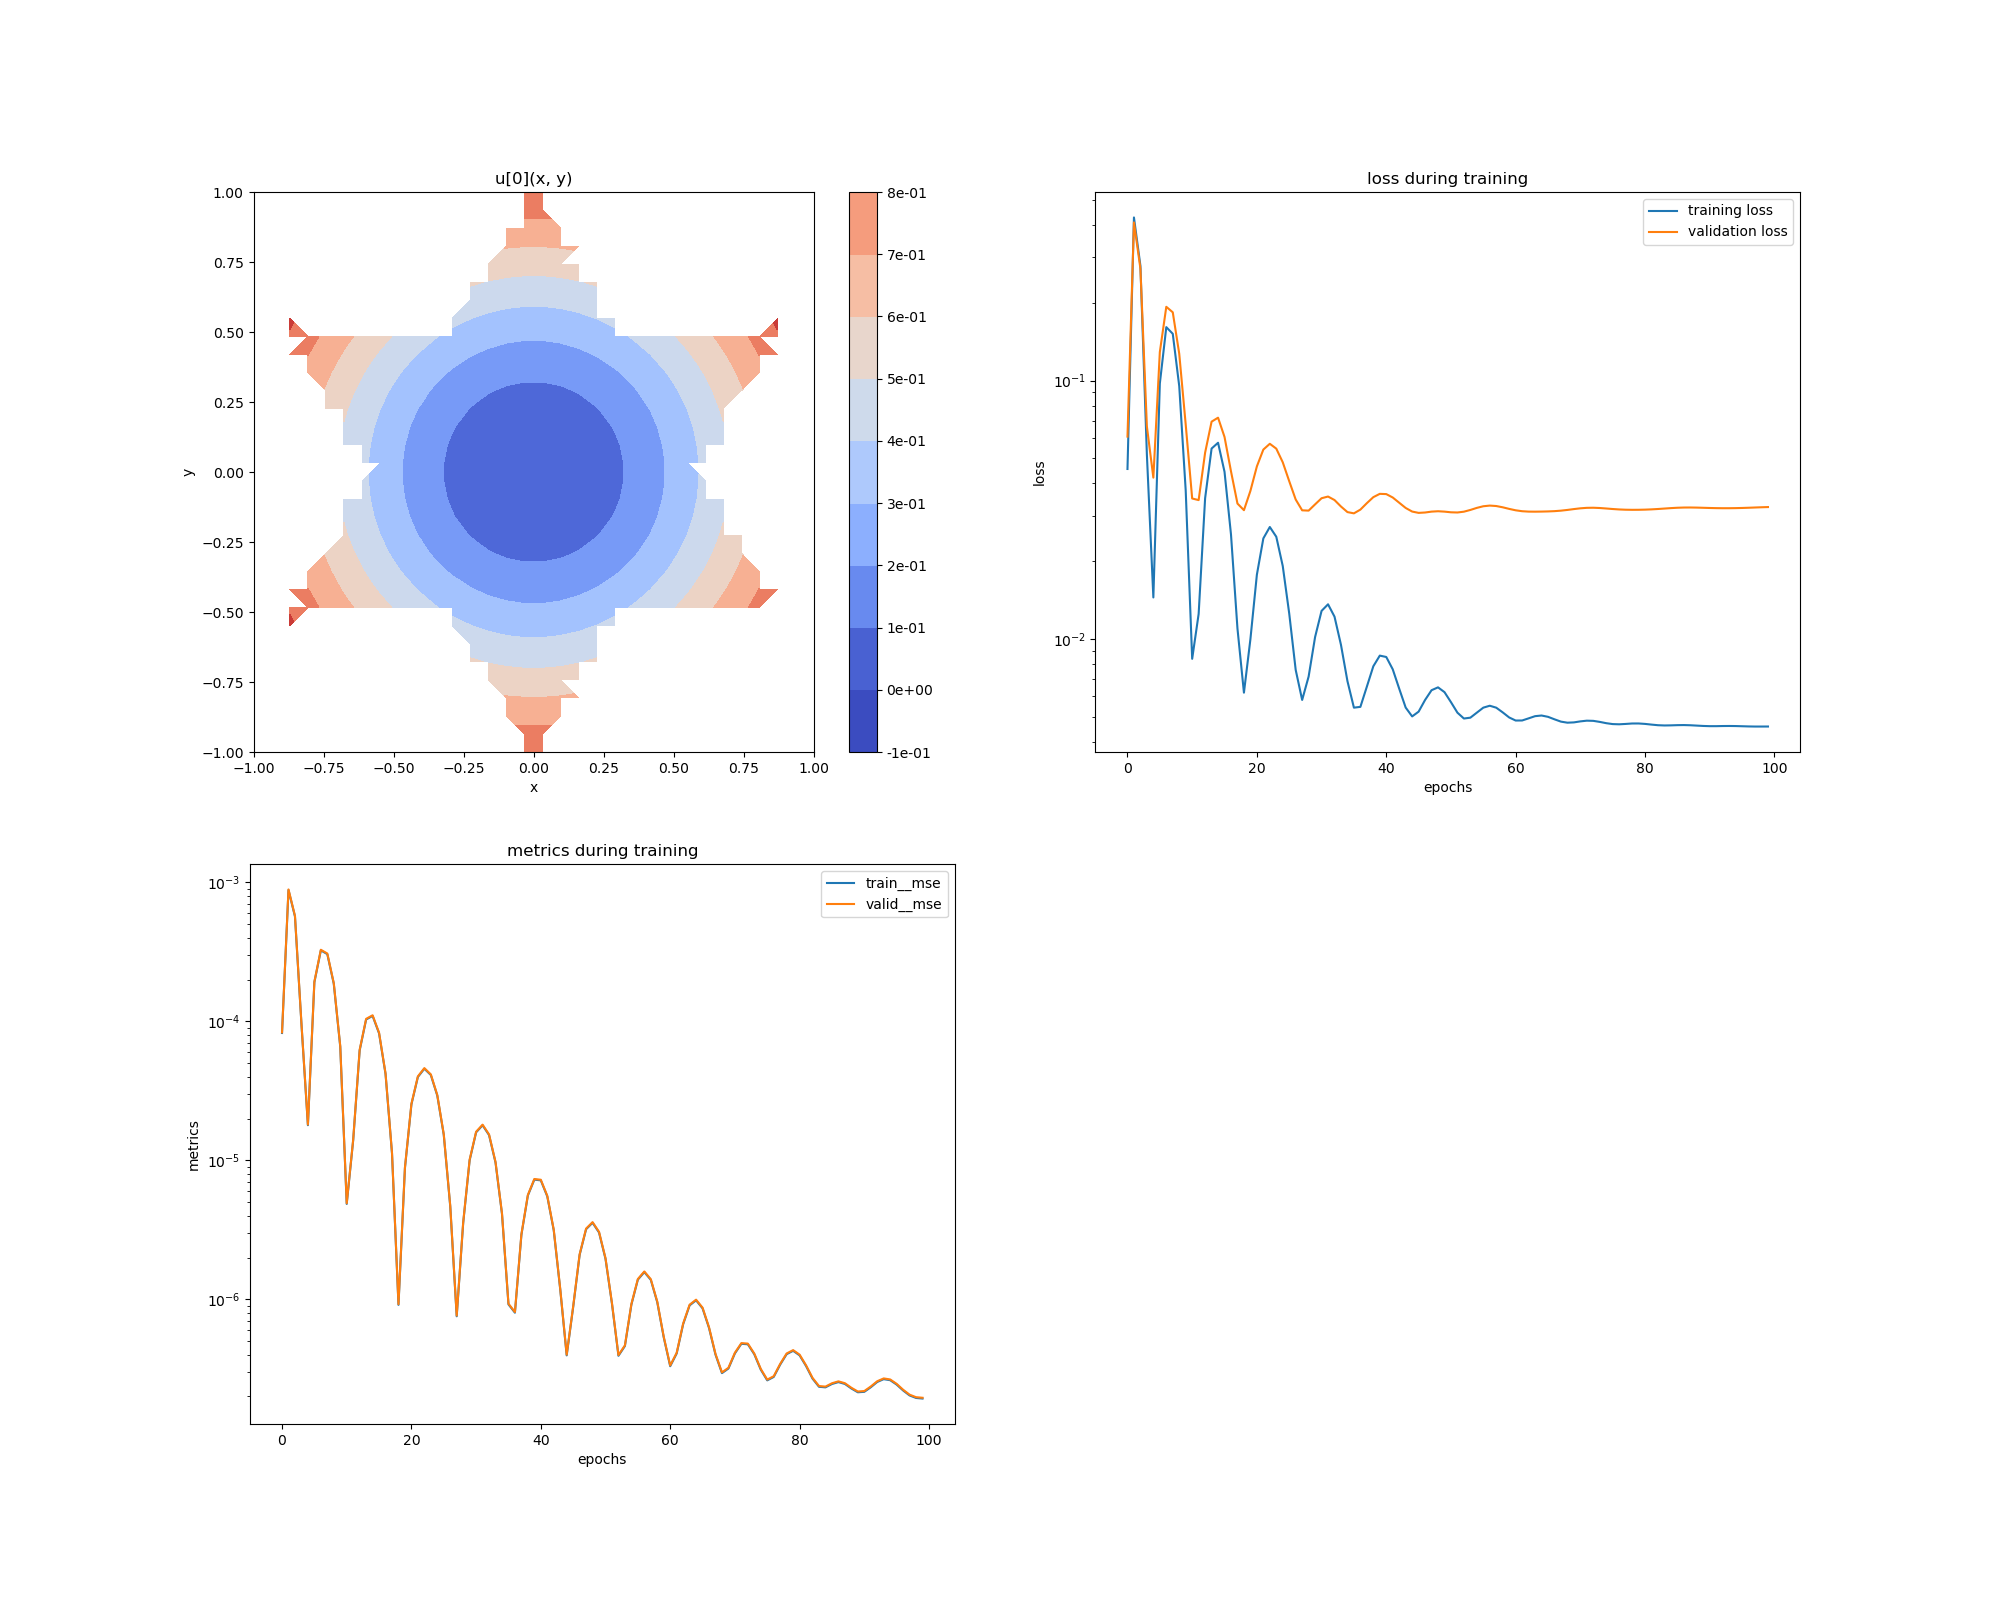

In [30]:
%matplotlib notebook
def mse(u, x, y):
    true_u = torch.log(1+x**2+y**2)
    return torch.mean( (u - true_u)**2 )

def de_star(u, x, y):
    return diff(u, x, order=2) + diff(u, y, order=2) + torch.exp(u) - 1.0 - x**2 - y**2 - 4.0/(1.0+x**2+y**2)**2

# fully connected network with one hidden layer (40 hidden units with Sigmoid activation)
net = FCNN(n_input_units=2, hidden_units=(40, 40), actv=nn.ELU)
adam = optim.Adam(params=net.parameters(), lr=0.01)

# train on 32 X 32 grid
solution_neural_net_star, history_star = solve2D(
    pde=de_star, condition=cdbc_star,
    xy_min=(-1, -1), xy_max=(1, 1),
    train_generator=train_gen, valid_generator=valid_gen,
    net=net, max_epochs=100, batch_size=torch.sum(is_in_domain_train).item(), optimizer=adam,
    monitor=Monitor2D(check_every=1, xy_min=(-1, -1), xy_max=(1, 1)),
    metrics={'mse': mse}
)

We can compare our approximation with the analytical solution:

<IPython.core.display.Javascript object>


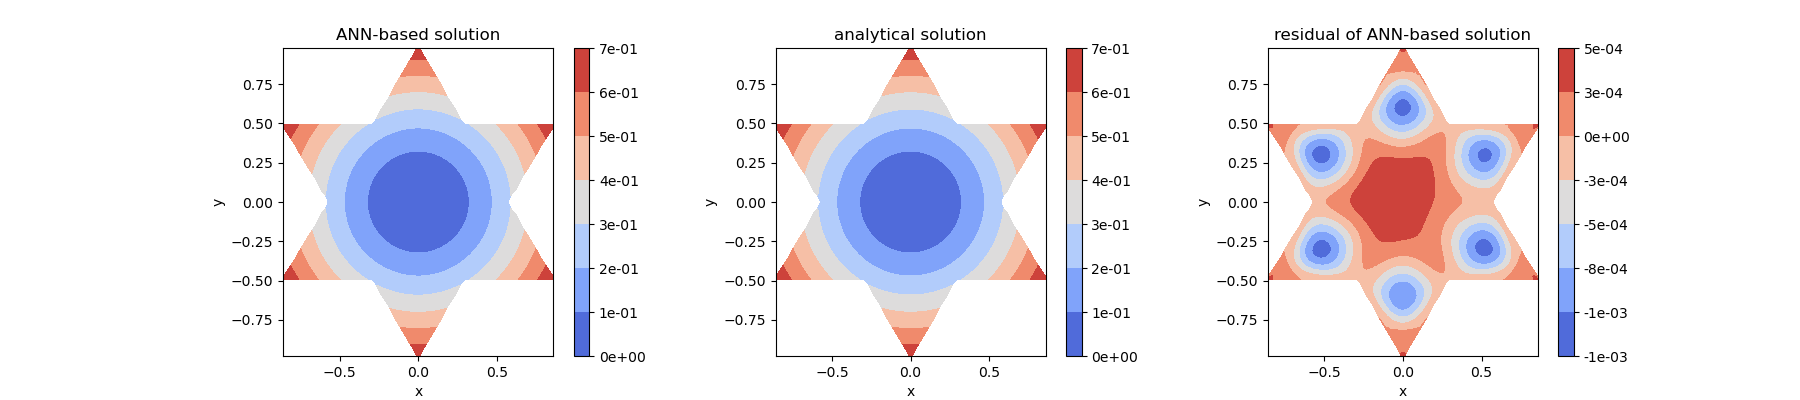

In [31]:
%matplotlib notebook
compare_contour(
    solution_neural_net_star, 
    solution_analytical_star,
    xx_valid, yy_valid, cdbc=cdbc_star
)